# Twitter Sentiment Analysis / Clasiffication Model analysis

### Data Description
The dataset being used is the <a href="https://www.kaggle.com/kazanova/sentiment140" target="_blank">sentiment140</a> dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

#### Data Details
It contains the following 6 fields: 
* **sentiment**: the polarity of the tweet (0 = negative, 4 = positive)
* **ids**: The id of the tweet (2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

#### Add additional description 

### Import necessary libraries

In [1]:
# DataFrame
import numpy as np
import pandas as pd
import re

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split

### Import Data

In [2]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df_encoding = 'latin-1'

In [3]:
df_raw = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', names = columns, header= None, encoding= df_encoding)

### EDA

In [4]:
df_raw.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
target    1600000 non-null int64
ids       1600000 non-null int64
date      1600000 non-null object
flag      1600000 non-null object
user      1600000 non-null object
text      1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
print("Dataset size:", len(df_raw))

Dataset size: 1600000


Let's look at one example of a negative and one example of positive tweet, to see what the data looks like:

In [7]:
print(df_raw[df_raw['target'] == 0]['text'][1])

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [8]:
print(df_raw[df_raw['target'] == 4]['text'][800001])

im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!


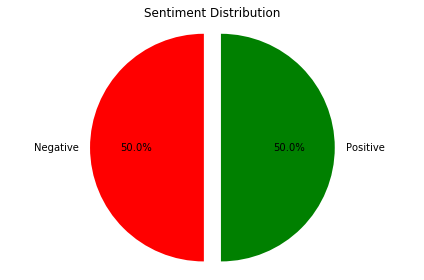

In [9]:
# sum the instances of males and females
negative = (df_raw['target'] == 0).sum()
positive = (df_raw['target'] == 4).sum()

# put them into a list called proportions
proportions = [negative, positive]

# Create a pie chart
plt.pie(
    # using proportions
    proportions,
    
    # with the labels being officer names
    labels = ['Negative', 'Positive'],
    
    # with no shadows
    shadow = False,
    
    # with colors
    colors = ['red','green'],
    
    # with one slide exploded out
    explode = (0.15 , 0),
    
    # with the start angle at 90%
    startangle = 90,
    
    # with the percent listed as a fraction
    autopct = '%1.1f%%'
    )

# View the plot drop above
plt.axis('equal')

# Set labels
plt.title("Sentiment Distribution")

# View the plot
plt.tight_layout()
plt.show()

### Data Cleaning

In [10]:
# Remove unnecessary columns
df = df_raw[['target', 'text']]

# Replace a value for positive tweets
df['target'].replace(to_replace = 4, value =1, inplace=True)

C:\Users\ogi.andjelov\RovaLab\env\rovalab_live\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [11]:
df['target'].value_counts()

1    800000
0    800000
Name: target, dtype: int64

Before we learn too much about the data, we will split it into a training set and a test set.

In [12]:
text, sentiment = list(df['text']), list(df['target'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42)

In [14]:
# Import nltk and define other data cleaning parameters

import nltk
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words('english')
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

# Define WordLemmatizer
# wordLemmatizer = WordNetLemmatizer()
# for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
#     print(word, "=>", wordLemmatizer.lemmatize(word))

# Define stemmer
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


### Transformer

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

class TweetToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_case=True, replace_url=True, replace_username=True, remove_punctuation=True, replace_numbers=True, remove_stopwords=True, stemming=True):
        self.lower_case = lower_case
        self.replace_url = replace_url
        self.replace_username = replace_username
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
        self.remove_stopwords = remove_stopwords
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for tweet in X:
            if self.lower_case:
                tweet = tweet.lower()
            if self.replace_url:
                tweet = re.sub(urlPattern,' URL',tweet)
            if self.replace_username:
                tweet = re.sub(userPattern,' USER', tweet)
            if self.replace_numbers:
                tweet = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', tweet)
            if self.remove_punctuation:
                tweet = re.sub(r'\W+', ' ', tweet, flags=re.M)
            if self.remove_stopwords:
                tweet=tweet.split()
                for word in list(tweet):
                    if word in stopwords:
                        tweet.remove(word)            
            word_counts = Counter(tweet)
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)               

In [16]:
X_few = X_train[:2]
X_few_wordcounts = TweetToWordCounterTransformer().fit_transform(X_few)
print(X_train[:2])
print(X_few_wordcounts)

["@jbtaylor WIth ya. &quot;I'd like a Palm Pre, Touchstone charger. ReadyNow? Yes, that sounds good. But is my beer ready now?'  #prelaunch", 'felt the earthquake this afternoon, it seems to be a , but  at the epicenter ']
[Counter({'user': 1, 'ya': 1, 'quot': 1, 'like': 1, 'palm': 1, 'pre': 1, 'touchston': 1, 'charger': 1, 'readynow': 1, 'ye': 1, 'sound': 1, 'good': 1, 'beer': 1, 'readi': 1, 'prelaunch': 1})
 Counter({'felt': 1, 'earthquak': 1, 'afternoon': 1, 'seem': 1, 'epicent': 1})]


# Testing

In [1]:
class car(): 
      
    # init method or constructor 
    def __init__(self, model, color): 
        self.model = model 
        self.color = color 
          
    def show(self): 
        print("Model is", self.model ) 
        print("color is", self.color ) 
          
# both objects have different self which  
# contain their attributes 
audi = car("audi a4", "blue") 
ferrari = car("ferrari 488", "green") 
  
audi.show()     # same output as car.show(audi) 
ferrari.show()  # same output as car.show(ferrari)

Model is audi a4
color is blue
Model is ferrari 488
color is green


In [2]:
car.show(audi)

Model is audi a4
color is blue


In [28]:
df_test = pd.DataFrame(df_raw['text'])

In [30]:
df_test['text'] = df_test['text'].astype(str)

In [32]:
df_test.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


In [33]:
df_test[df_test['text'].str.contains("http")]

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
37,@MissXu sorry! bed time came here (GMT+1) ht...
50,Broadband plan 'a massive broken promise' http...
74,Why won't you show my location?! http://twit...
95,Strider is a sick little puppy http://apps.fa...
100,Body Of Missing Northern Calif. Girl Found: P...
106,Emily will be glad when Mommy is done training...
170,Crazy wind today = no birding http://ff.im/1XTTi
181,Check out my mug http://www.erika-obscura.blo...
310,http://twitpic.com/2y2wr - according to my bro...


#### Testing Lemmatization

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TweetToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_case=True, replace_url=True, replace_username=True, remove_punctuation=True, replace_numbers=True, lemmatize=True):
        self.lower_case = lower_case
        self.replace_url = replace_url
        self.replace_username = replace_username
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
        self.lemmatize = lemmatize
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for tweet in X:
            if self.lower_case:
                tweet = tweet.lower()
            if self.replace_url:
                tweet = re.sub(urlPattern,' URL',tweet)
            if self.replace_username:
                tweet = re.sub(userPattern,' USER', tweet)
            if self.replace_numbers:
                tweet = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', tweet)
            if self.remove_punctuation:
                tweet = re.sub(r'\W+', ' ', tweet, flags=re.M)
            word_counts = Counter(tweet.split())
            if self.lemmatize and wordLemmatizer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = wordLemmatizer.lemmatize(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed) 

In [ ]:
X_few = X_train[:2]
X_few_wordcounts = TweetToWordCounterTransformer().fit_transform(X_few)
print(X_train[:2])
print(X_few_wordcounts)

#### Testing Stopwords removal

In [54]:
stopwords = nltk.corpus.stopwords.words('english')

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class TweetToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_case=True, replace_url=True, replace_username=True, remove_punctuation=True, replace_numbers=True, remove_stopwords=True, stemming=True):
        self.lower_case = lower_case
        self.replace_url = replace_url
        self.replace_username = replace_username
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
        self.remove_stopwords = remove_stopwords
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for tweet in X:
            if self.lower_case:
                tweet = tweet.lower()
            if self.replace_url:
                tweet = re.sub(urlPattern,' URL',tweet)
            if self.replace_username:
                tweet = re.sub(userPattern,' USER', tweet)
            if self.replace_numbers:
                tweet = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', tweet)
            if self.remove_punctuation:
                tweet = re.sub(r'\W+', ' ', tweet, flags=re.M)
            if self.remove_stopwords:
                tweet=tweet.split()
                for word in list(tweet):
                    if word in stopwords:
                        tweet.remove(word)            
            word_counts = Counter(tweet)
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)       

In [67]:
test = df['text'][2].split()
# test = df['text'][2]

In [68]:
test

['@Kenichan',
 'I',
 'dived',
 'many',
 'times',
 'for',
 'the',
 'ball.',
 'Managed',
 'to',
 'save',
 '50%',
 'The',
 'rest',
 'go',
 'out',
 'of',
 'bounds']

In [69]:
for word in list(test):  # iterating on a copy since removing will mess things up
    if word in stopwords:
        test.remove(word)

In [70]:
test

['@Kenichan',
 'I',
 'dived',
 'many',
 'times',
 'ball.',
 'Managed',
 'save',
 '50%',
 'The',
 'rest',
 'go',
 'bounds']

In [78]:
X_few = X_train[:10]
X_few_wordcounts = TweetToWordCounterTransformer().fit_transform(X_few)
print(X_train[:10])
print(X_few_wordcounts)

["@jbtaylor WIth ya. &quot;I'd like a Palm Pre, Touchstone charger. ReadyNow? Yes, that sounds good. But is my beer ready now?'  #prelaunch", 'felt the earthquake this afternoon, it seems to be a , but  at the epicenter ', 'Ruffles on shirts are like so in, me Likey ', 'Pretty bad night into a crappy morning....FML! If only buttface didnt say he could go into work today ', '@dcbriccetti yeah, what a clear view! ', 'One more time Follow my fam #FF @georgeann13 @nakithebeatman @flimackgod @chaz81 @djt_elle @jaejaedynomite welcome to Friday Follow me 2 ', '@MsJBell U rock!!! Thanks.  Will be added to next RobCrotch (tm) video. ', "@ssnider yes please! met your fiancee at ian's party the other day, btw... she's very sweet  congrats to you guys!", "My gawd! They've finished the whole bowl before I even posted my previous tweet! Making 2nd bowl ", "@marty_k awesome game. but very short. you'll finish it and be craving for more God Of War action "]
[Counter({'user': 1, 'ya': 1, 'quot': 1, 'li

# Word count vectorization

In [17]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [18]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<2x11 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

In [19]:
X_few_vectors.toarray()

array([[5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [20]:
vocab_transformer.vocabulary_

{'user': 1,
 'ya': 2,
 'quot': 3,
 'like': 4,
 'palm': 5,
 'pre': 6,
 'touchston': 7,
 'charger': 8,
 'readynow': 9,
 'ye': 10}

In [21]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("tweet_to_wordcount", TweetToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# Model Data

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV]  ................................................................
[CV] ....................... , score=0.7504939449266055, total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] ....................... , score=0.7502900388359072, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s


[CV] ....................... , score=0.7508847670074484, total=   9.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.2s finished


0.7505562502566536

In [23]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 73.82%
Recall: 77.80%


In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
print(confusion_matrix(y_test, y_pred))

[[115208  44286]
 [ 35625 124881]]


#### Reference
* **Hands-on Machine Learning with Scikit-Learn & TensorFlow**

# Testing other models

In [22]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

C:\Users\ogi.andjelov\RovaLab\env\rovalab_live\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [24]:
# Define models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver="lbfgs", random_state=42),]

In [25]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_transformed, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

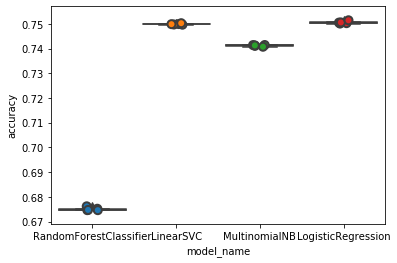

In [26]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [27]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.749905
LogisticRegression        0.750598
MultinomialNB             0.741204
RandomForestClassifier    0.675045
Name: accuracy, dtype: float64

#### Best model

In [29]:
X_test_transformed = preprocess_pipeline.fit_transform(X_test)

model = LogisticRegression(solver="lbfgs", random_state=42)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.59      0.56      0.57    159494
          1       0.58      0.62      0.60    160506

avg / total       0.59      0.59      0.59    320000



# WordCounterToVector Breakdown

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))